# VGG16 Image Classification with PyTorch

This notebook implements a VGG16-based image classifier using PyTorch. The model uses transfer learning with a pre-trained VGG16 backbone and custom classifier layers for binary classification.

## Environment Setup
First, let's check the PyTorch installation and GPU availability.

In [6]:
import torch

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("GPU count:", torch.cuda.device_count())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")

PyTorch version: 2.5.1+cu121
CUDA available: True
GPU count: 1
GPU name: NVIDIA GeForce RTX 3050 Laptop GPU


## Import Libraries
Import all necessary libraries for deep learning, data processing, and visualization.

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Model Setup
Set up the device and load pre-trained VGG16 model. We freeze the feature extraction layers and only train the classifier.

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

base_model = models.vgg16(pretrained=True)
base_model.features.requires_grad_(False)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

## Custom VGG Model
Define a custom model class that combines VGG16 features with a custom classifier for binary classification.

The model architecture:
- VGG16 feature extractor (frozen)
- Adaptive average pooling
- Fully connected layers with dropout
- Output layer with 2 classes

In [9]:
class VGGModel(nn.Module):
    def __init__(self):
        super(VGGModel, self).__init__()
        self.features = base_model.features
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((7, 7)),
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 2)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = VGGModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()


## Data Loading and Training

### Data Preprocessing
- **Training transforms**: Resize, random horizontal flip, color jitter, normalization
- **Validation transforms**: Resize and normalization only

### Training Configuration
- **Batch size**: 32
- **Epochs**: 10
- **Optimizer**: Adam with learning rate 1e-4
- **Loss function**: CrossEntropyLoss

The training loop includes progress tracking and validation after each epoch.

In [10]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_valid = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder('C:\\Users\\Asus\\IE4483\\IE4483datasets\\datasets\\train', transform=transform_train)
valid_dataset = datasets.ImageFolder('C:\\Users\\Asus\\IE4483\\IE4483datasets\\datasets\\val', transform=transform_valid)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

print(f"Starting training on {device}")
print(f"Train samples: {len(train_dataset)}, Validation samples: {len(valid_dataset)}")

for epoch in range(10):
    print(f"Epoch {epoch+1}/10")
    
    model.train()
    train_loss, train_correct = 0, 0
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == labels).sum().item()
        
        if batch_idx % 10 == 0:
            print(f"  Batch {batch_idx}/{len(train_loader)}")
    
    model.eval()
    val_loss, val_correct = 0, 0
    
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            val_correct += (outputs.argmax(1) == labels).sum().item()
    
    train_acc = train_correct / len(train_dataset)
    val_acc = val_correct / len(valid_dataset)
    
    history['loss'].append(train_loss / len(train_loader))
    history['accuracy'].append(train_acc)
    history['val_loss'].append(val_loss / len(valid_loader))
    history['val_accuracy'].append(val_acc)
    
    print(f"  Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss/len(valid_loader):.4f}, Val Acc: {val_acc:.4f}")

print("Training completed!")


Starting training on cuda
Train samples: 20000, Validation samples: 5000
Epoch 1/10
  Batch 0/625
  Batch 0/625
  Batch 10/625
  Batch 10/625
  Batch 20/625
  Batch 20/625
  Batch 30/625
  Batch 30/625
  Batch 40/625
  Batch 40/625
  Batch 50/625
  Batch 50/625
  Batch 60/625
  Batch 60/625
  Batch 70/625
  Batch 70/625
  Batch 80/625
  Batch 80/625
  Batch 90/625
  Batch 90/625
  Batch 100/625
  Batch 100/625
  Batch 110/625
  Batch 110/625
  Batch 120/625
  Batch 120/625
  Batch 130/625
  Batch 130/625
  Batch 140/625
  Batch 140/625
  Batch 150/625
  Batch 150/625
  Batch 160/625
  Batch 160/625
  Batch 170/625
  Batch 170/625
  Batch 180/625
  Batch 180/625
  Batch 190/625
  Batch 190/625
  Batch 200/625
  Batch 200/625
  Batch 210/625
  Batch 210/625
  Batch 220/625
  Batch 220/625
  Batch 230/625
  Batch 230/625
  Batch 240/625
  Batch 240/625
  Batch 250/625
  Batch 250/625
  Batch 260/625
  Batch 260/625
  Batch 270/625
  Batch 270/625
  Batch 280/625
  Batch 280/625
  Batch 29

## Training Visualization
Plot the training and validation accuracy and loss curves to visualize model performance over epochs.

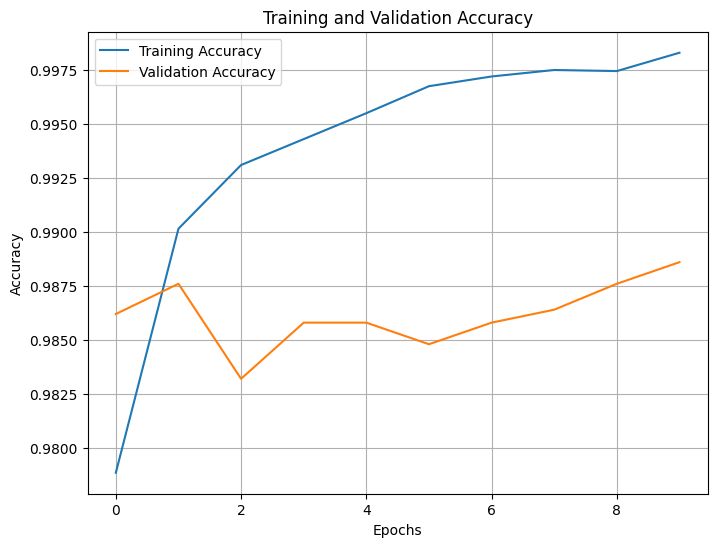

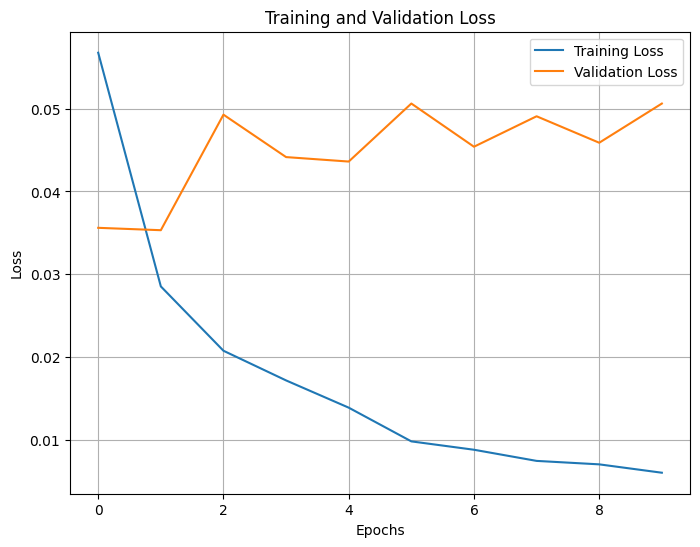

In [12]:
# Accuracy curves
plt.figure(figsize=(8, 6))
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss curves
plt.figure(figsize=(8, 6))
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Model Saving
Save the trained model weights for future use.

In [13]:
torch.save(model.state_dict(), 'vgg16_custom_model.pth')


## Model Evaluation on Test Data

Evaluate the trained model on unclassified test images using a CSV file with ground truth labels.

### Process:
1. Load test images and labels from CSV file
2. Apply the same preprocessing as validation data
3. Make predictions using the trained model
4. Calculate accuracy and generate confusion matrix
5. Save results to CSV file

The evaluation includes:
- **Test accuracy calculation**
- **Confusion matrix visualization**
- **Results export for further analysis**

Loaded CSV with 500 entries
Loading and preprocessing images...
  Processed 50/500 images
  Processed 50/500 images
  Processed 100/500 images
  Processed 100/500 images
  Processed 150/500 images
  Processed 150/500 images
  Processed 200/500 images
  Processed 200/500 images
  Processed 250/500 images
  Processed 250/500 images
  Processed 300/500 images
  Processed 300/500 images
  Processed 350/500 images
  Processed 350/500 images
  Processed 400/500 images
  Processed 400/500 images
  Processed 450/500 images
  Processed 450/500 images
  Processed 500/500 images
Loaded 500 images
Making predictions...
  Processed 500/500 images
Loaded 500 images
Making predictions...
  Predicted 50/500 images
  Predicted 50/500 images
  Predicted 100/500 images
  Predicted 100/500 images
  Predicted 150/500 images
  Predicted 150/500 images
  Predicted 200/500 images
  Predicted 200/500 images
  Predicted 250/500 images
  Predicted 250/500 images
  Predicted 300/500 images
  Predicted 300/500 ima

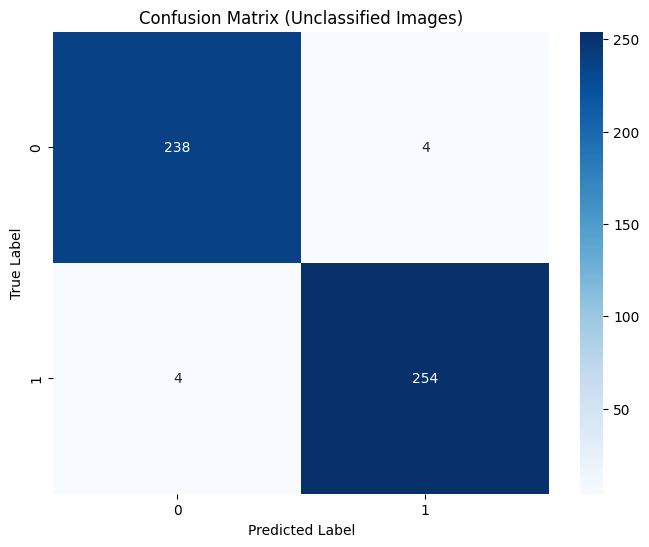

Saving results...
Results saved to C:\Users\Asus\IE4483\IE4483datasets\datasets\VGGpredicted_labels.csv


In [16]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

csv_path = r"C:\Users\Asus\IE4483\IE4483datasets\datasets\testClassification.csv"
img_dir = r"C:\Users\Asus\IE4483\IE4483datasets\datasets\test_unclassified"
output_csv = r"C:\Users\Asus\IE4483\IE4483datasets\datasets\VGGpredicted_labels.csv"

df = pd.read_csv(csv_path, header=None, names=["filename", "label"])
print(f"Loaded CSV with {len(df)} entries")

images = []
true_labels = []
filenames = []

print("Loading and preprocessing images...")
for i, (_, row) in enumerate(df.iterrows()):
    fname = str(row["filename"])
    label = int(row["label"])
    img_path = os.path.join(img_dir, f"{fname}.jpg")
    if not os.path.exists(img_path):
        continue

    img = Image.open(img_path).convert('RGB')
    img_tensor = transform_valid(img).unsqueeze(0).to(device)
    images.append(img_tensor)
    true_labels.append(label)
    filenames.append(fname)
    
    if (i + 1) % 50 == 0:
        print(f"  Processed {i + 1}/{len(df)} images")

print(f"Loaded {len(images)} images")

model.eval()
predicted_classes = []

print("Making predictions...")
with torch.no_grad():
    for i, img_tensor in enumerate(images):
        output = model(img_tensor)
        predicted_classes.append(output.argmax(1).cpu().item())
        
        if (i + 1) % 50 == 0:
            print(f"  Predicted {i + 1}/{len(images)} images")

true_labels = np.array(true_labels)
predicted_classes = np.array(predicted_classes)

accuracy = np.mean(predicted_classes == true_labels)
print(f"Test Accuracy: {accuracy:.4f}")

print("Generating confusion matrix...")
cm = confusion_matrix(true_labels, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Unclassified Images)')
plt.show()

print("Saving results...")
results_df = pd.DataFrame({
    "filename": filenames,
    "true_label": true_labels,
    "predicted_label": predicted_classes
})
results_df.to_csv(output_csv, index=False)
print(f"Results saved to {output_csv}")
